<a href="https://colab.research.google.com/github/Ogunfool/Prognostics-Strategies-An-Aero-engine-Use-case/blob/main/A_Residual_Similarity_Based_Method_for_Remaining_Useful_Life_Prediction_Using_Degradation_Degree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import necessary libraries.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import math
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load and Plot Initial Data - Exploratory Data Analysis

Helper Functions


In [ ]:
np.set_printoptions(suppress=True, linewidth=100, precision=2)

In [ ]:
# Checkpoints - List and npy files
# np.save() - Saves a single array in a binary numpy format
def checkpoints(filename, checkpoint_data):
  np.save(filename, checkpoint_data)
  checkpoint_variable = np.load(filename + '.npy') #Load so that we always have an on-hand version of the checkpoint
  return(checkpoint_variable)

# List Checkpoint
def list_checkpoints(filename, checkpoint_data):
  np.save(filename, checkpoint_data, allow_pickle=True)
  checkpoint_variable = np.load(filename + '.npy', allow_pickle=True) #Load so that we always have an on-hand version of the checkpoint
  return(checkpoint_variable)

In [ ]:
# Plots
# Line Plot Function - Array Plot
def plot_func(sensor_header, header_names, data_list):
  for sensor_n in sensor_header:
    for d_ind in range(10):
      plt.plot(data_list[d_ind][:,header_names.index(sensor_n)], label = 'ensemble-'+str(d_ind))
      plt.legend(loc='upper right')
      plt.title(sensor_n)
    plt.show()

# Side-by-side Plot Function: For array
def cycle_plot_func_a(data, sensor_n_list, n_samp=1010):
  if sensor_n_list is None:
    for n in range(data.shape[1]):
      plt.plot(data[:n_samp,n],c='teal')
      for m in [148,416,621,855,1008]:
        plt.axvline(x = m, color = 'salmon', label = 'axvline - full height')
      plt.title('sensor'+str(n+1))
      plt.show()
  else:
      for n in sensor_n_list:
        plt.plot(data[:n_samp,n-1],c='sienna')
        for m in [148,416,621,855,1008]:
          plt.axvline(x = m, color = 'peru', label = 'axvline - full height')
        plt.title('sensor'+str(n))
        plt.show()

# Side-by-side Plot Function: For dataframe: Just first 5 instances (Try to combine both later)
def cycle_plot_func(sensor_header, data, n_samp):
  for sensor_n in sensor_header:
    data[sensor_n][:n_samp].plot(c='teal')
    for m in [148,416,621,855,1008]:
      plt.axvline(x = m, color = 'salmon', label = 'axvline - full height')
    plt.title(sensor_n)
    plt.show()

# # Arguments: Breakpoints, no of instances and dataframe.
def plot_funct(df, breakpoints, no):
  y = np.arange(df.iloc[:breakpoints[no]].shape[0])
  for pt in df.columns:
    fig, ax = plt.subplots()
    ax.plot(y,df.iloc[:breakpoints[no]][pt], color='teal');
    for m in breakpoints[:no]:
      plt.axvline(x = m, color = 'black', label = 'axvline - full height')
    ax.set_title(pt)

Implementation details

In [ ]:
# Load dataset
# Some exloratory analysis - Check for Monotonicity
# Divide dataset by machines
# Split train-val data 
# Working Regime clustering
# Trendability Analysis - Fit a linear degradation model (Average slope across all 208 instances of each sensor)
# Select most trended sensors 
# Construct health Indicator for all instances - i.e Create degradation profile for each component
# Train a linear regression model - Evaluate on val set, note that test data points wouldn't have a failure data in them and we would like to predict the health index
# at any given time (LSTM) would be a better estimator 
# Build similarity RUL model
# Performance Evaluation

Load Data.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving train_FD002.txt to train_FD002.txt


In [ ]:
# Create headers
index_col_names=['unit_id','time_cycle']
operat_set_col_names=['op_conditions_{}'.format(i) for i in range(1,4)]
sensor_measure_col_names=['sensor_{}'.format(i) for i in range(1,22)]
all_col=index_col_names+operat_set_col_names+sensor_measure_col_names
print(all_col)

['unit_id', 'time_cycle', 'op_conditions_1', 'op_conditions_2', 'op_conditions_3', 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21']


In [ ]:
# Import Data - NASA dataset 260 train trajectories, 259 tests and 6 conditions
raw_train_df=pd.read_csv('/content/train_FD002.txt',delim_whitespace=True,names=all_col)
raw_train_df.head()

unit_id  time_cycle  op_conditions_1  op_conditions_2  op_conditions_3  \
0        1           1          34.9983           0.8400            100.0   
1        1           2          41.9982           0.8408            100.0   
2        1           3          24.9988           0.6218             60.0   
3        1           4          42.0077           0.8416            100.0   
4        1           5          25.0005           0.6203             60.0   

   sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_12  \
0    449.44    555.32   1358.61   1137.23      5.48  ...     183.06   
1    445.00    549.90   1353.22   1125.78      3.91  ...     130.42   
2    462.54    537.31   1256.76   1047.45      7.05  ...     164.22   
3    445.00    549.51   1354.03   1126.38      3.91  ...     130.72   
4    462.54    537.07   1257.71   1047.93      7.05  ...     164.31   

   sensor_13  sensor_14  sensor_15  sensor_16  sensor_17  sensor_18  \
0    2387.72    8048.56     9.3461       0.02        334       2223   
1    2387.66    8072.30     9.3774       0.02        330       2212   
2    2028.03    7864.87    10.8941       0.02        309       1915   
3    2387.61    8068.66     9.3528       0.02        329       2212   
4    2028.00    7861.23    10.8963       0.02        309       1915   

   sensor_19  sensor_20  sensor_21  
0     100.00      14.73     8.8071  
1     100.00      10.41     6.2665  
2      84.93      14.08     8.6723  
3     100.00      10.59     6.4701  
4      84.93      14.13     8.5286  

[5 rows x 26 columns]

In [ ]:
raw_train_df.info()

A list of instances or data for seperate machines.


In [ ]:
vals = raw_train_df.values
data_list = []  # List of arrays
for i in np.unique(raw_train_df['unit_id'].values):
  ind = np.where(raw_train_df['unit_id'].values == i)
  data_list.append(vals[ind])

In [ ]:
len(data_list)

260

In [ ]:
data_list[3][:,3].shape

(235,)

In [ ]:
checkpoint_data_list = list_checkpoints('data-list',data_list)

Plot.

In [ ]:
n_samples = 10
header_names = list(raw_train_df.columns)
sensor_header = list(header_names[-21:])

In [ ]:
len(header_names)

26

In [ ]:
sensor_header 

In [ ]:
header_names.index('sensor_3')

7

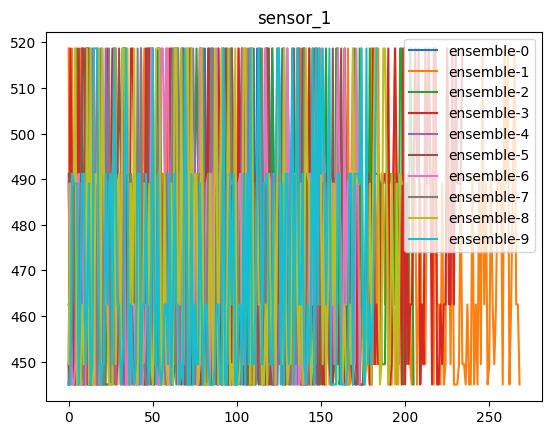

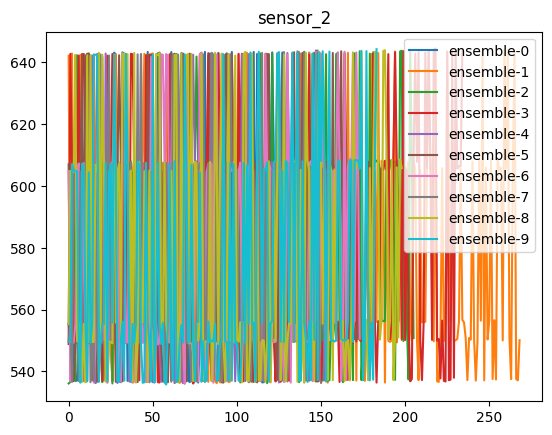

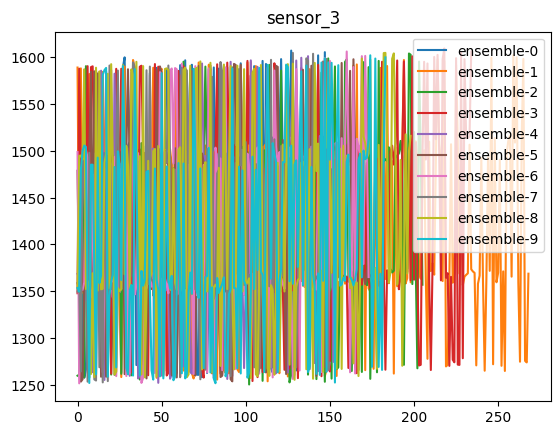

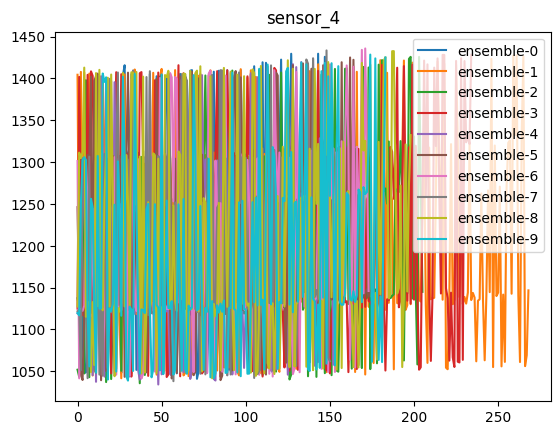

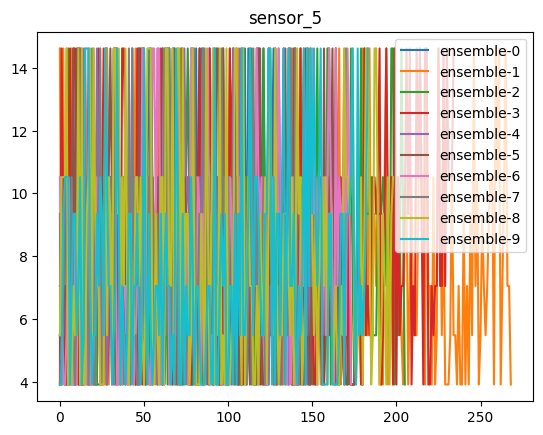

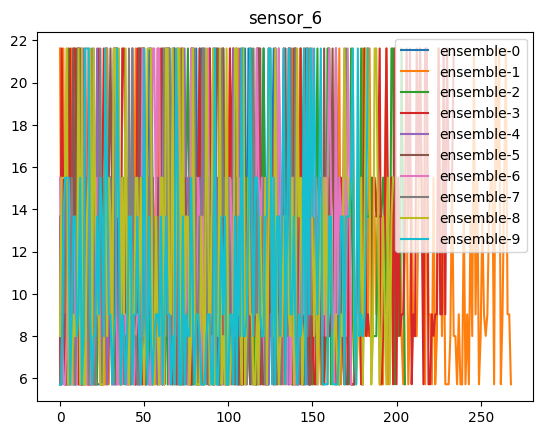

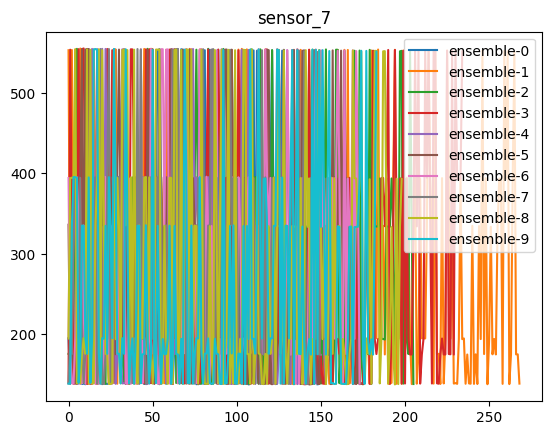

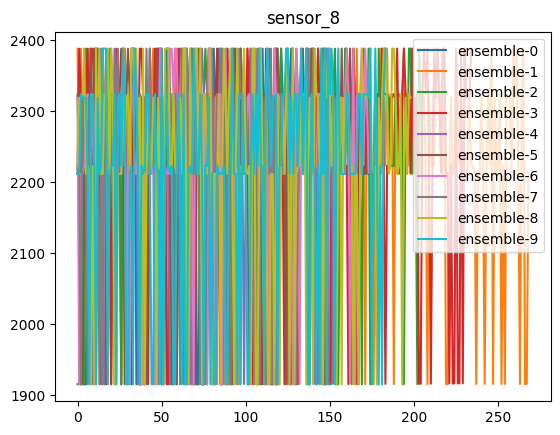

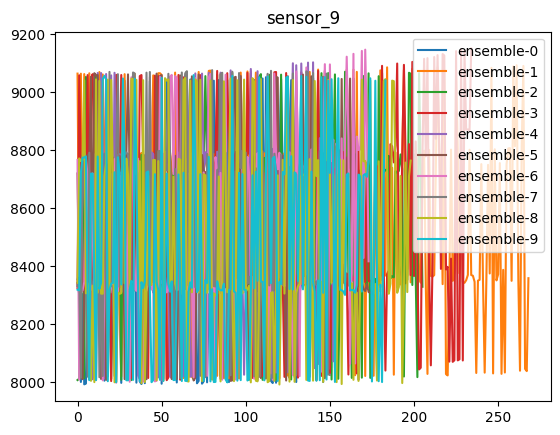

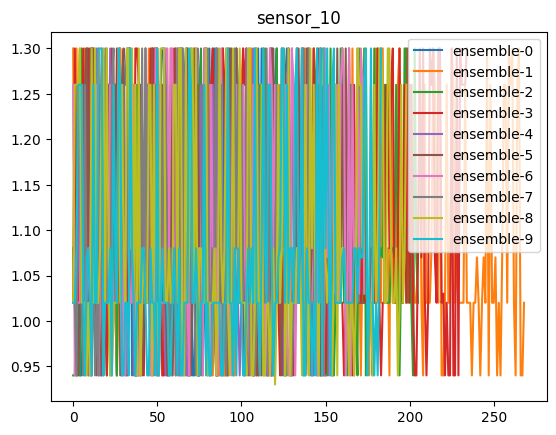

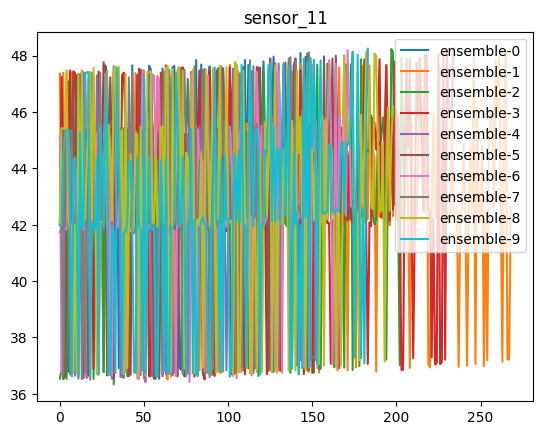

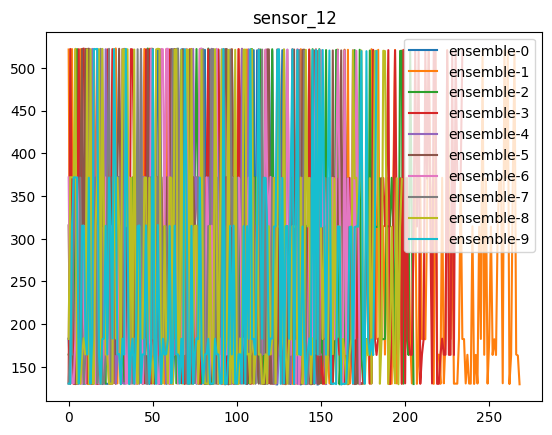

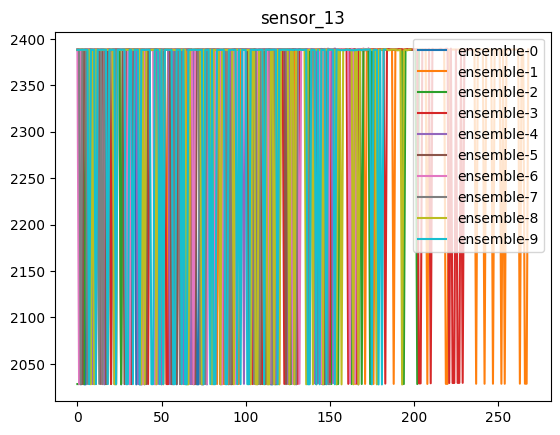

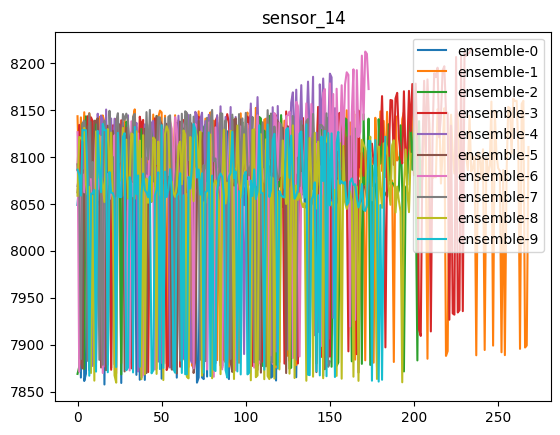

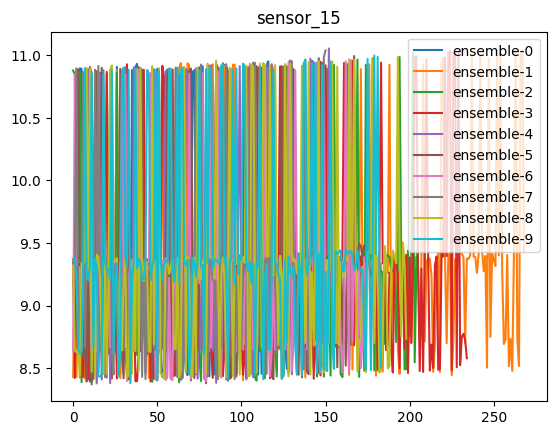

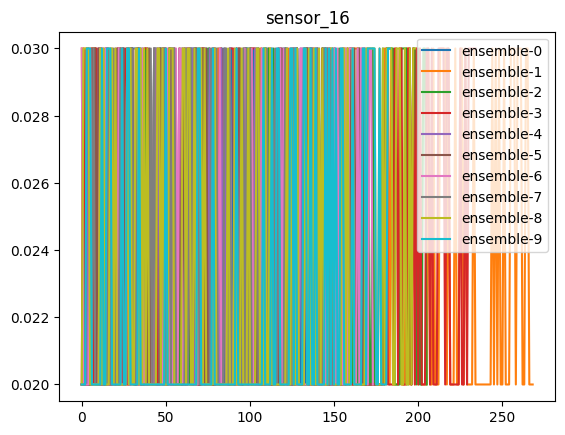

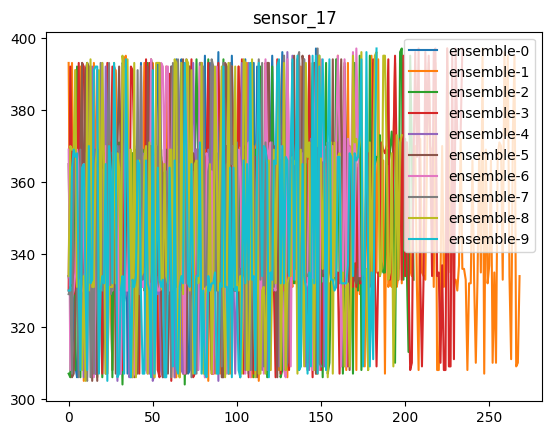

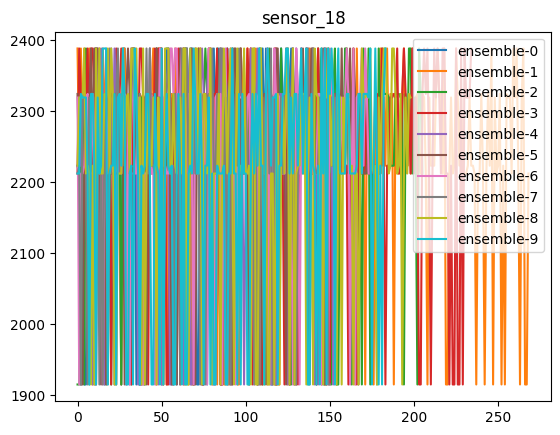

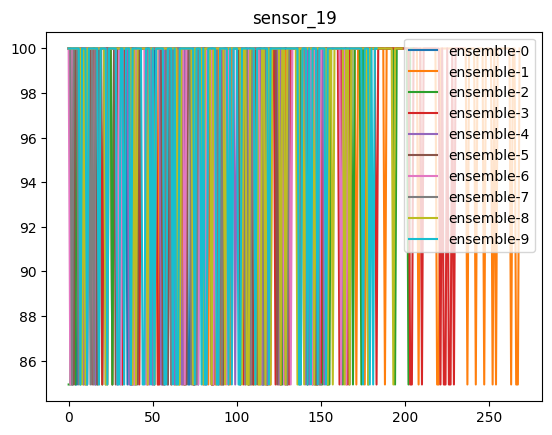

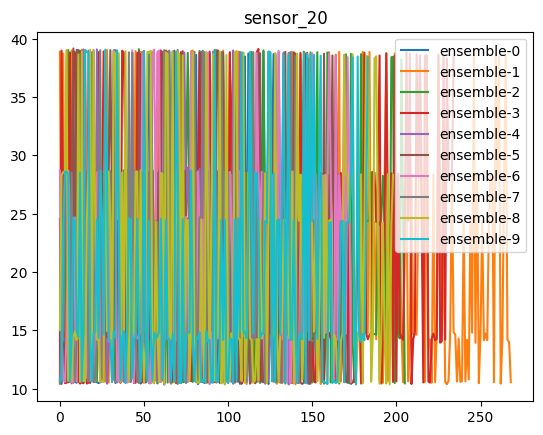

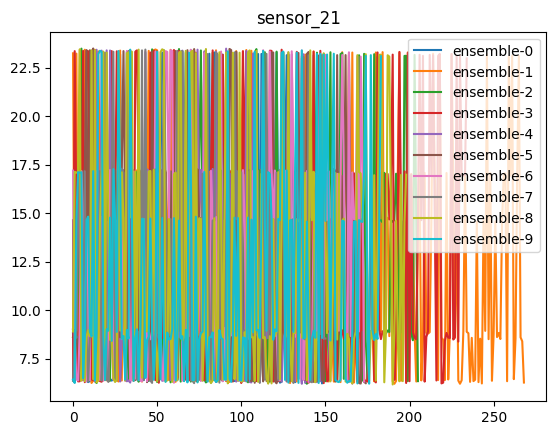

In [ ]:
plot_func(sensor_header, header_names, data_list)

Cycle plot

In [ ]:
cycle_plot_func(sensor_header=sensor_header, data = raw_train_df)

In [ ]:
# New Breakpoints
unit_size = raw_train_df.groupby('unit_id').size()
breakpoints = unit_size.cumsum()
breakpoints.shape

(260,)

In [ ]:
plot_funct(raw_train_df, breakpoints,5)

Summary Statistics

In [ ]:
stats = raw_train_df.describe()
raw_train_df.describe()

unit_id    time_cycle  op_conditions_1  op_conditions_2  \
count  53759.000000  53759.000000     53759.000000     53759.000000   
mean     131.082981    109.154746        23.998407         0.572056   
std       74.463862     69.180569        14.747376         0.310016   
min        1.000000      1.000000         0.000000         0.000000   
25%       68.000000     52.000000        10.004600         0.250700   
50%      131.000000    104.000000        25.001300         0.700000   
75%      195.000000    157.000000        41.998000         0.840000   
max      260.000000    378.000000        42.008000         0.842000   

       op_conditions_3      sensor_1      sensor_2      sensor_3  \
count     53759.000000  53759.000000  53759.000000  53759.000000   
mean         94.046020    472.910207    579.672399   1419.971013   
std          14.237735     26.389707     37.289399    105.946341   
min          60.000000    445.000000    535.530000   1243.730000   
25%         100.000000    445.000000    549.570000   1352.760000   
50%         100.000000    462.540000    555.980000   1369.180000   
75%         100.000000    491.190000    607.340000   1499.370000   
max         100.000000    518.670000    644.520000   1612.880000   

           sensor_4      sensor_5  ...     sensor_12     sensor_13  \
count  53759.000000  53759.000000  ...  53759.000000  53759.000000   
mean    1205.442024      8.031986  ...    266.069034   2334.557253   
std      119.123428      3.613839  ...    137.659507    128.068271   
min     1023.770000      3.910000  ...    129.120000   2027.610000   
25%     1123.655000      3.910000  ...    131.520000   2387.900000   
50%     1138.890000      7.050000  ...    183.200000   2388.080000   
75%     1306.850000     10.520000  ...    371.260000   2388.170000   
max     1439.230000     14.620000  ...    523.370000   2390.480000   

          sensor_14     sensor_15     sensor_16     sensor_17     sensor_18  \
count  53759.000000  53759.000000  53759.000000  53759.000000  53759.000000   
mean    8066.597682      9.329654      0.023326    348.309511   2228.806358   
std       84.837950      0.749335      0.004711     27.754515    145.327980   
min     7848.360000      8.335700      0.020000    303.000000   1915.000000   
25%     8062.140000      8.677800      0.020000    331.000000   2212.000000   
50%     8082.540000      9.310900      0.020000    335.000000   2223.000000   
75%     8127.195000      9.386900      0.030000    369.000000   2324.000000   
max     8268.500000     11.066900      0.030000    399.000000   2388.000000   

          sensor_19     sensor_20     sensor_21  
count  53759.000000  53759.000000  53759.000000  
mean      97.756838     20.789296     12.473423  
std        5.364067      9.869331      5.921615  
min       84.930000     10.180000      6.010500  
25%      100.000000     10.910000      6.546300  
50%      100.000000     14.880000      8.929200  
75%      100.000000     28.470000     17.083200  
max      100.000000     39.340000     23.590100  

[8 rows x 26 columns]

In [ ]:
stats_df = pd.DataFrame(stats, columns=all_col)

In [ ]:
# df.min() method
raw_train_df['sensor_1'].min()

445.0

Train-Validation Data Split



In [ ]:
wrap_train_data = data_list[:200]
wrap_val_data = data_list[200:]

In [ ]:
# Size of unwrapped val and train set
unwrap_sums = 0
for unwraps in wrap_val_data:
  unwrap_sums += unwraps.shape[0]
unwrap_val_lenght = unwrap_sums
unwrap_train_lenght =  len(raw_train_df) - unwrap_val_lenght

In [ ]:
unwrap_val_lenght

12303

In [ ]:
unwrap_train_data = raw_train_df.values[:unwrap_train_lenght]
unwrap_val_data = raw_train_df.values[unwrap_train_lenght:]

In [ ]:
unwrap_val_data.shape[0]

12303

In [ ]:
print(len(unwrap_train_data), len(unwrap_val_data))
print(len(wrap_train_data), len(wrap_val_data))

41456 12303
200 60


In [ ]:
wrap_val_data[1].shape

(197, 26)

In [ ]:
unwrap_train_data

array([[  1.  ,   1.  ,  35.  , ..., 100.  ,  14.73,   8.81],
       [  1.  ,   2.  ,  42.  , ..., 100.  ,  10.41,   6.27],
       [  1.  ,   3.  ,  25.  , ...,  84.93,  14.08,   8.67],
       ...,
       [200.  , 225.  ,  10.01, ..., 100.  ,  28.15,  16.88],
       [200.  , 226.  ,  20.01, ..., 100.  ,  24.23,  14.65],
       [200.  , 227.  ,  42.  , ..., 100.  ,  10.55,   6.22]])

In [ ]:
np.unique(unwrap_train_data[:,0])

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,
        16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,
        31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,
        46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,
        61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,
        76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,
        91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105.,
       106., 107., 108., 109., 110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132., 133., 134., 135.,
       136., 137., 138., 139., 140., 141., 142., 143., 144., 145., 146., 147., 148., 149., 150.,
       151., 152., 153., 154.,

In [ ]:
unwrap_val_data

array([[201.  ,   1.  ,  25.  , ...,  84.93,  14.44,   8.6 ],
       [201.  ,   2.  ,  42.  , ..., 100.  ,  10.69,   6.36],
       [201.  ,   3.  ,  42.  , ..., 100.  ,  10.7 ,   6.28],
       ...,
       [260.  , 314.  ,  25.  , ...,  84.93,  14.19,   8.55],
       [260.  , 315.  ,  25.  , ...,  84.93,  14.05,   8.37],
       [260.  , 316.  ,  35.  , ..., 100.  ,  14.75,   8.84]])

In [ ]:
np.unique(unwrap_val_data[:,0])

array([201., 202., 203., 204., 205., 206., 207., 208., 209., 210., 211., 212., 213., 214., 215.,
       216., 217., 218., 219., 220., 221., 222., 223., 224., 225., 226., 227., 228., 229., 230.,
       231., 232., 233., 234., 235., 236., 237., 238., 239., 240., 241., 242., 243., 244., 245.,
       246., 247., 248., 249., 250., 251., 252., 253., 254., 255., 256., 257., 258., 259., 260.])

# Working Regimen Normalization And Feature Extraction Section.

In [ ]:
# K-Means: Find Clusters and Find mean & std of clusters (Put in a dataframe)
# Stack/Unwrap data back to have a full train data cycle - raw_train_df_normalized

# Seperate the Operating conditions columns
op_condts_index = [2,3,4]
op_condts_data = unwrap_train_data[:,op_condts_index]
print(op_condts_data.shape)

(41456, 3)


In [ ]:
np.unique(op_condts_data[:,2])

array([ 60., 100.])

In [ ]:
# Use K-means to find clusters
# Run the Kmeans algorithm
kmeans = KMeans(n_clusters=6) # Greedy k-means is used when the n_clusters is not specified, it enables faster convergence
kmeans.fit(op_condts_data)
train_cluster_labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [ ]:
# It is amazing that we got the same centroids with sklearn as we did with MATLAB
centroids

array([[ 42.  ,   0.84, 100.  ],
       [ 10.  ,   0.25, 100.  ],
       [ 25.  ,   0.62,  60.  ],
       [ 20.  ,   0.7 , 100.  ],
       [  0.  ,   0.  , 100.  ],
       [ 35.  ,   0.84, 100.  ]])

In [ ]:
train_cluster_labels.size

41456

In [ ]:
# Let's predict the closest cluster each sample in the validation set belongs to
val_cluster_labels = kmeans.predict(unwrap_val_data[:,op_condts_index])
print(val_cluster_labels.shape)

(12303,)


In [ ]:
val_cluster_labels

array([2, 0, 0, ..., 2, 2, 5], dtype=int32)

In [ ]:
# Working Regimen Helper Functions
# Cluster parameters function
no_clusters=6
def parameters_form(no_clusters, data, cluster_labels):
  parameters_mean_list = []
  parameters_std_list = []
  for label in range(no_clusters):
    cluster = data[cluster_labels == label]
    meaan = np.mean(cluster, axis = 0)
    stdd = np.std(cluster, axis = 0)
    parameters_mean_list.append(meaan)
    parameters_std_list.append(stdd)
  print(len(parameters_mean_list), len(parameters_std_list))
  return parameters_mean_list, parameters_std_list

# Normalize function
def normalize(X,mean,std):
  return (X - mean) / std

# Normalized unwrap data function
def normalize_regime(temp_data, cluster_labels, parameters_mean_list, parameters_std_list):
  # New Normalized with clusters dataset before split
  normalized_unwrap_train_data = np.zeros_like(temp_data)
  for clu in np.unique(cluster_labels):
    mm = normalize(temp_data[np.argwhere(cluster_labels==clu)].squeeze(),parameters_mean_list[clu],parameters_std_list[clu])
    # Fill newdataset @ every iteration
    normalized_unwrap_train_data [np.argwhere(cluster_labels==clu).squeeze()] = mm
  return normalized_unwrap_train_data

In [ ]:
parameters_mean_list, parameters_std_list = parameters_form(no_clusters=no_clusters, data=unwrap_train_data[:,-21:], cluster_labels=train_cluster_labels)

6 6


In [ ]:
parameters_mean_list

[array([ 445.  ,  549.7 , 1354.38, 1127.63,    3.91,    5.72,  138.63, 2211.97, 8327.95,    1.02,
          42.14,  130.55, 2388.06, 8089.54,    9.37,    0.02,  331.04, 2212.  ,  100.  ,   10.59,
           6.35]),
 array([ 489.05,  604.91, 1501.92, 1311.09,   10.52,   15.49,  394.33, 2318.96, 8785.46,    1.26,
          45.48,  371.45, 2388.16, 8135.24,    8.66,    0.03,  369.68, 2319.  ,  100.  ,   28.53,
          17.12]),
 array([ 462.54,  536.86, 1262.63, 1050.19,    7.05,    9.03,  175.43, 1915.42, 8015.62,    0.94,
          36.8 ,  164.58, 2028.32, 7878.64,   10.91,    0.02,  307.33, 1915.  ,   84.93,   14.26,
           8.56]),
 array([ 491.19,  607.55, 1485.44, 1252.92,    9.35,   13.66,  334.51, 2324.02, 8729.82,    1.08,
          44.44,  314.89, 2388.15, 8066.06,    9.23,    0.02,  365.35, 2324.  ,  100.  ,   24.46,
          14.67]),
 array([ 518.67,  642.67, 1590.28, 1408.61,   14.62,   21.61,  553.38, 2388.1 , 9062.87,    1.3 ,
          47.54,  521.42, 2388.1 , 8141.79

In [ ]:
# I want to save parameters list as a pandas dataframe
columns = sensor_header
index = ['1','2','3','4','5','6']
parameters_mean_df = pd.DataFrame(parameters_mean_list, columns=columns, index=index)
parameters_mean_df   # I only need the cluster means

sensor_1    sensor_2     sensor_3     sensor_4  sensor_5   sensor_6  \
1    445.00  549.699496  1354.381449  1127.629679      3.91   5.715802   
2    489.05  604.908158  1501.921205  1311.085043     10.52  15.493224   
3    462.54  536.859334  1262.625370  1050.194983      7.05   9.027772   
4    491.19  607.551505  1485.437315  1252.918088      9.35  13.656494   
5    518.67  642.665256  1590.283259  1408.607252     14.62  21.609805   
6    449.44  555.789067  1366.604161  1131.353344      5.48   8.000284   

     sensor_7     sensor_8     sensor_9  sensor_10  ...   sensor_12  \
1  138.633918  2211.974877  8327.952464   1.020242  ...  130.554289   
2  394.333871  2318.956633  8785.458163   1.259997  ...  371.452465   
3  175.432760  1915.420083  8015.624889   0.939921  ...  164.575707   
4  334.509509  2324.020019  8729.819162   1.077795  ...  314.888528   
5  553.381096  2388.098158  9062.871505   1.300000  ...  521.421373   
6  194.452714  2223.044507  8356.274797   1.020415  ...  183.031936   

     sensor_13    sensor_14  sensor_15  sensor_16   sensor_17  sensor_18  \
1  2388.055659  8089.539903   9.374190   0.020000  331.044149     2212.0   
2  2388.160090  8135.240223   8.664023   0.030000  369.675719     2319.0   
3  2028.318661  7878.635968  10.912931   0.020000  307.326640     1915.0   
4  2388.152698  8066.057741   9.231505   0.022069  365.347729     2324.0   
5  2388.097303  8141.787801   8.441434   0.030000  393.166478     2388.0   
6  2388.142393  8072.422383   9.331274   0.020000  334.207008     2223.0   

   sensor_19  sensor_20  sensor_21  
1     100.00  10.587596   6.351769  
2     100.00  28.528057  17.116958  
3      84.93  14.264345   8.560009  
4     100.00  24.457621  14.674515  
5     100.00  38.821301  23.292560  
6     100.00  14.832942   8.898663  

[6 rows x 21 columns]

In [ ]:
#  Do the same for std parameters
columns = sensor_header
index = ['1','2','3','4','5','6']
parameters_std_df = pd.DataFrame(parameters_std_list, columns=columns, index=index)
parameters_std_df   # I only need the cluster means

sensor_1  sensor_2  sensor_3  sensor_4      sensor_5  sensor_6  \
1  0.000000e+00  0.435544  5.662543  7.653836  5.626610e-13  0.004935   
2  3.524292e-11  0.477902  5.788777  8.466277  1.408651e-12  0.004674   
3  2.870593e-11  0.357989  5.297395  6.861601  3.339551e-13  0.004169   
4  4.604317e-11  0.467910  5.855488  7.860531  9.769963e-13  0.004778   
5  4.411049e-11  0.500476  6.067535  9.001533  4.600764e-13  0.001384   
6  4.490630e-11  0.440150  5.665252  7.477050  2.566836e-13  0.001662   

   sensor_7  sensor_8   sensor_9     sensor_10  ...  sensor_12  sensor_13  \
1  0.438685  0.295149  17.667444  1.536545e-03  ...   0.339297   0.318267   
2  0.677363  0.095615  17.913264  1.792443e-04  ...   0.540285   0.098726   
3  0.450687  0.259688  14.033521  8.872573e-04  ...   0.344186   0.274372   
4  0.611481  0.123212  16.742250  4.146150e-03  ...   0.498524   0.126740   
5  0.874064  0.071927  18.719632  1.274536e-13  ...   0.742699   0.071908   
6  0.483875  0.276084  16.763679  1.994401e-03  ...   0.378960   0.296246   

   sensor_14  sensor_15     sensor_16  sensor_17  sensor_18     sensor_19  \
1  16.175275   0.038056  3.115563e-15   1.412706        0.0  0.000000e+00   
2  15.768615   0.038269  1.013079e-15   1.493658        0.0  0.000000e+00   
3  12.896840   0.043063  1.203898e-15   1.291402        0.0  6.082246e-12   
4  14.742249   0.039078  4.050767e-03   1.470169        0.0  0.000000e+00   
5  16.149891   0.037168  1.013079e-15   1.535066        0.0  0.000000e+00   
6  15.264574   0.038594  1.210837e-15   1.409101        0.0  0.000000e+00   

   sensor_20  sensor_21  
1   0.108320   0.064413  
2   0.145599   0.086650  
3   0.111623   0.065862  
4   0.135509   0.080260  
5   0.179010   0.106358  
6   0.113910   0.067477  

[6 rows x 21 columns]

Put it All Together: Normalize Train Data, Checkpoint wrap and unwrap normalized train data

In [ ]:
# Create temp unwrap data - 21 columns (only sensors)
print(np.unique(train_cluster_labels))
temp_unwrap_train_data = unwrap_train_data[:,-21:]
parameters_mean_list, parameters_std_list = parameters_form(no_clusters=6, data=temp_unwrap_train_data, cluster_labels = train_cluster_labels)
print(parameters_mean_list[1].shape)
normalized_unwrap_train_data = normalize_regime(temp_data = temp_unwrap_train_data, cluster_labels = train_cluster_labels, 
                                                parameters_mean_list=parameters_mean_list, 
                                                parameters_std_list=parameters_std_list)

In [ ]:
# Some checks
print(unwrap_val_data.shape)
print(np.isnan(normalized_unwrap_train_data).sum())   # Count NAns due to division error

(12303, 26)
87111


In [ ]:
normalized_unwrap_train_data[2000:2010]   # Some checks with MATLAB results

In [ ]:
normalized_unwrap_train_data  # Before 

array([[ 1.  , -1.07, -1.41, ...,   nan, -0.9 , -1.36],
       [  nan,  0.46, -0.21, ...,   nan, -1.64, -1.32],
       [-1.  ,  1.26, -1.11, ...,  1.  , -1.65,  1.7 ],
       ...,
       [ 1.  ,  0.67,  2.14, ...,   nan, -2.6 , -2.73],
       [ 1.  ,  2.18,  1.83, ...,   nan, -1.68, -0.32],
       [  nan,  2.23,  3.01, ...,   nan, -0.35, -2.1 ]])

In [ ]:
# Fill NANs with 0
normalized_unwrap_train_data[np.isnan(normalized_unwrap_train_data)] = 0
print(np.isnan(normalized_unwrap_train_data).sum())

0


In [ ]:
normalized_unwrap_train_data # After - No more NANs

array([[ 1.  , -1.07, -1.41, ...,  0.  , -0.9 , -1.36],
       [ 0.  ,  0.46, -0.21, ...,  0.  , -1.64, -1.32],
       [-1.  ,  1.26, -1.11, ...,  1.  , -1.65,  1.7 ],
       ...,
       [ 1.  ,  0.67,  2.14, ...,  0.  , -2.6 , -2.73],
       [ 1.  ,  2.18,  1.83, ...,  0.  , -1.68, -0.32],
       [ 0.  ,  2.23,  3.01, ...,  0.  , -0.35, -2.1 ]])

In [ ]:
print(unwrap_train_data.shape)
print(normalized_unwrap_train_data.shape)

(41456, 26)
(41456, 21)


In [ ]:
# Get missing part
conc_part = unwrap_train_data[:unwrap_train_data.shape[0],:5]
print(conc_part.shape)
# Add missing part
normalized_unwrap_train_fdata = np.concatenate((conc_part,normalized_unwrap_train_data), axis=1)
print(normalized_unwrap_train_fdata.shape)

(41456, 5)
(41456, 26)


In [ ]:
np.unique(normalized_unwrap_train_fdata[:,0])

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,
        16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,
        31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,
        46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,
        61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,
        76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,
        91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105.,
       106., 107., 108., 109., 110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132., 133., 134., 135.,
       136., 137., 138., 139., 140., 141., 142., 143., 144., 145., 146., 147., 148., 149., 150.,
       151., 152., 153., 154.,

In [ ]:
# The Split Function (For numpy_array)
no_ensemble_members = 200
def split_func(data, no_ensemble_members):
  data_arr_list = []  # List of arrays
  for i in range(no_ensemble_members):
    ind = np.where(data[:,0] == i+1)
    data_arr_list.append(data[ind])
  return data_arr_list

In [ ]:
normalized_unwrap_train_fdata[np.where(normalized_unwrap_train_fdata[:,0] == 1)].shape

(149, 26)

In [ ]:
normalized_train_data_list = split_func(data = normalized_unwrap_train_fdata, no_ensemble_members=no_ensemble_members)

In [ ]:
print(len(normalized_train_data_list))

200


In [ ]:
normalized_train_data_list[1].shape

(269, 26)

Val Data Normalization - Use parameters mean_std for normalization... 

In [ ]:
unwrap_val_data.shape

(12303, 26)

In [ ]:
parameters_mean_list[0].shape

(21,)

In [ ]:
# Create temp unwrap data - 21 columns (only sensors)
print(np.unique(train_cluster_labels))
temp_unwrap_val_data = unwrap_val_data[:,-21:]
normalized_unwrap_val_data = normalize_regime(temp_data = temp_unwrap_val_data, cluster_labels = val_cluster_labels, 
                                                parameters_mean_list=parameters_mean_list, 
                                                parameters_std_list=parameters_std_list)

In [ ]:
# Some checks
print(unwrap_val_data.shape)
print(np.isnan(normalized_unwrap_val_data).sum())   # Count NAns due to division error

(12303, 26)
25863


In [ ]:
normalized_unwrap_val_data  # Before 

array([[-1.  , -1.09, -1.56, ...,  1.  ,  1.57,  0.6 ],
       [  nan, -2.34, -0.5 , ...,   nan,  0.95,  0.11],
       [  nan, -1.4 , -0.7 , ...,   nan,  1.04, -1.16],
       ...,
       [-1.  ,  1.73,  2.57, ...,  1.  , -0.67, -0.15],
       [-1.  ,  2.74,  1.95, ...,  1.  , -1.92, -2.84],
       [ 1.  ,  1.93,  1.41, ...,   nan, -0.73, -0.8 ]])

In [ ]:
# Fill NANs with 0
normalized_unwrap_val_data[np.isnan(normalized_unwrap_val_data)] = 0
print(np.isnan(normalized_unwrap_val_data).sum())

0


In [ ]:
normalized_unwrap_val_data # After - No more NANs

array([[-1.  , -1.09, -1.56, ...,  1.  ,  1.57,  0.6 ],
       [ 0.  , -2.34, -0.5 , ...,  0.  ,  0.95,  0.11],
       [ 0.  , -1.4 , -0.7 , ...,  0.  ,  1.04, -1.16],
       ...,
       [-1.  ,  1.73,  2.57, ...,  1.  , -0.67, -0.15],
       [-1.  ,  2.74,  1.95, ...,  1.  , -1.92, -2.84],
       [ 1.  ,  1.93,  1.41, ...,  0.  , -0.73, -0.8 ]])

In [ ]:
np.unique(unwrap_val_data[:,0])

array([201., 202., 203., 204., 205., 206., 207., 208., 209., 210., 211., 212., 213., 214., 215.,
       216., 217., 218., 219., 220., 221., 222., 223., 224., 225., 226., 227., 228., 229., 230.,
       231., 232., 233., 234., 235., 236., 237., 238., 239., 240., 241., 242., 243., 244., 245.,
       246., 247., 248., 249., 250., 251., 252., 253., 254., 255., 256., 257., 258., 259., 260.])

In [ ]:
np.unique(unwrap_train_data[:,0])

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,
        16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,
        31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,
        46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,
        61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,
        76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,
        91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105.,
       106., 107., 108., 109., 110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132., 133., 134., 135.,
       136., 137., 138., 139., 140., 141., 142., 143., 144., 145., 146., 147., 148., 149., 150.,
       151., 152., 153., 154.,

In [ ]:
print(unwrap_val_data.shape)
print(normalized_unwrap_val_data.shape)

(12303, 26)
(12303, 21)


In [ ]:
# Get missing part
conc_part = unwrap_val_data[:unwrap_val_data.shape[0],:5]
print(conc_part.shape)
# Add missing part
normalized_unwrap_val_fdata = np.concatenate((conc_part,normalized_unwrap_val_data), axis=1)
print(normalized_unwrap_val_fdata.shape)

(12303, 5)
(12303, 26)


In [ ]:
# Split Val normalized data
data_arr_list = []  # List of arrays
for i in np.unique(unwrap_val_data[:,0]):
  ind = np.where(normalized_unwrap_val_fdata[:,0] == i)
  data_arr_list.append(normalized_unwrap_val_fdata[ind])


In [ ]:
normalized_val_data_list = data_arr_list

In [ ]:
print(len(normalized_val_data_list), len(normalized_train_data_list))   # Don't use first val data, it is the same as last train data

60 200


In [ ]:
normalized_val_data_list[0].shape 

(191, 26)

In [ ]:
normalized_train_data_list[-1].shape

(227, 26)

Checkpoint Necessary Data

In [ ]:
# Shape Checks
print(len(wrap_train_data), len(wrap_val_data))
print(unwrap_train_data.shape, unwrap_val_data.shape)
print(normalized_unwrap_train_data.shape, normalized_unwrap_train_fdata.shape, normalized_unwrap_val_data.shape, normalized_unwrap_val_fdata.shape)
print(len(normalized_train_data_list), len(normalized_val_data_list))

200 60
(41456, 26) (12303, 26)
(41456, 21) (41456, 26) (12303, 21) (12303, 26)
200 60


In [ ]:
# Just Collect All my data in one place
# Unnormalized train and val data lists
checkpoint_train_data_list = list_checkpoints('wrap_train_data', wrap_train_data)
checkpoint_val_data_list = list_checkpoints('wrap_val_data', wrap_val_data)

# Unwrapped Unnormalized train and val data
checkpoint_unwrap_train_data = checkpoints('unwrap-train-data', unwrap_train_data)
checkpoint_unwrap_val_data = checkpoints('unwrap-val-data', unwrap_val_data)

# Unwrapped and Normalized train val data
checkpoint_normalized_unwrap_train_data = checkpoints('normalized-unwrap-train-data', normalized_unwrap_train_data)
checkpoint_normalized_unwrap_train_fdata = checkpoints('normalized-unwrap-train-fdata', normalized_unwrap_train_fdata)
checkpoint_normalized_unwrap_val_data = checkpoints('normalized-unwrap-val-data', normalized_unwrap_val_data)
checkpoint_normalized_unwrap_val_fdata = checkpoints('normalized-unwrap-val-fdata', normalized_unwrap_val_fdata)

# Normalized Data lists
checkpoint_normalized_train_data_list = list_checkpoints('normalized-train-data-list', normalized_train_data_list)
checkpoint_normalized_val_data_list = list_checkpoints('normalized-val-data-list', normalized_val_data_list)

# Cluster Labels
checkpoint_train_cluster_labels = checkpoints('train-cluster-labels', train_cluster_labels)
checkpoint_val_cluster_labels= checkpoints('val-cluster-labels', val_cluster_labels)


checkpoint_parameter_mean_list = list_checkpoints('parameters-mean-list', parameters_mean_list)
checkpoint_parameter_std_list = list_checkpoints('parameters-std-list', parameters_std_list)

Plot data again after Working Regimen Normalization and the trend in the data becomes more visible.

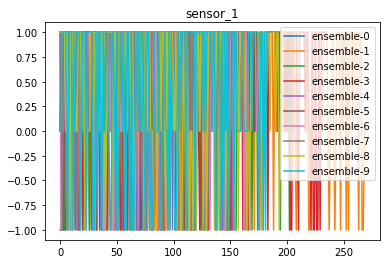

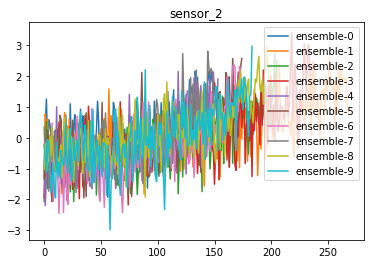

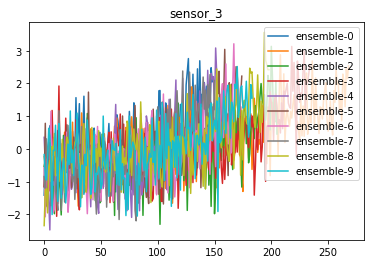

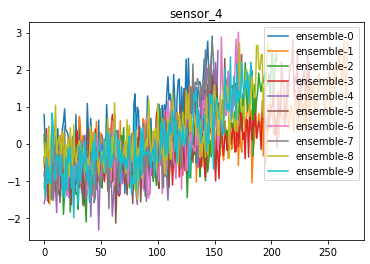

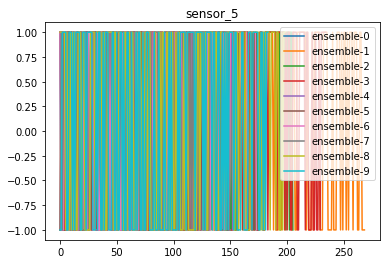

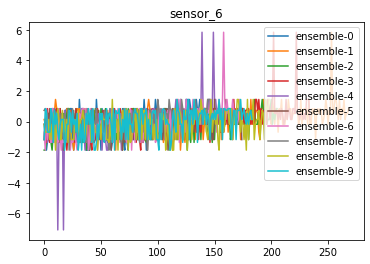

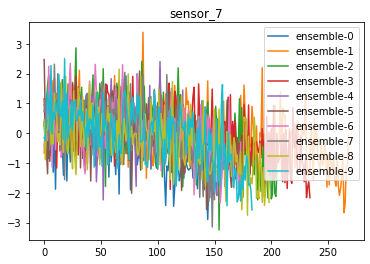

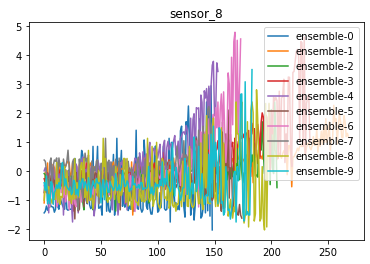

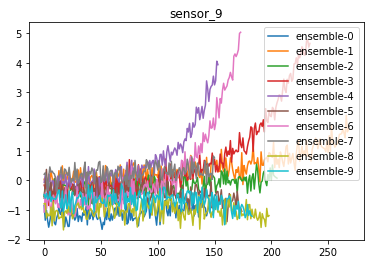

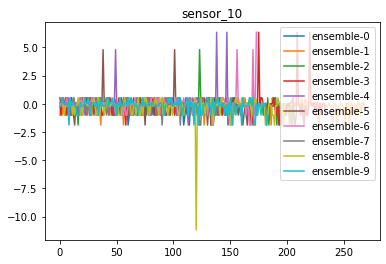

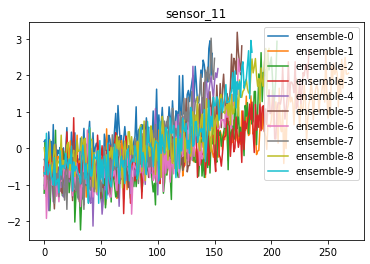

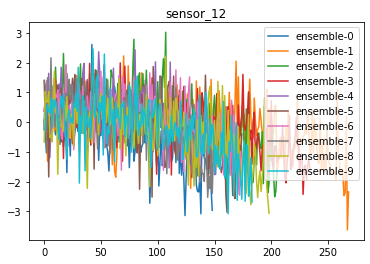

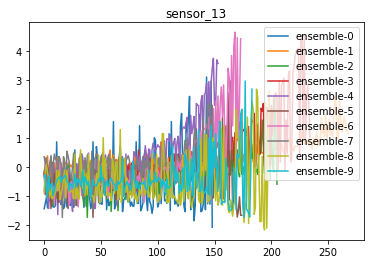

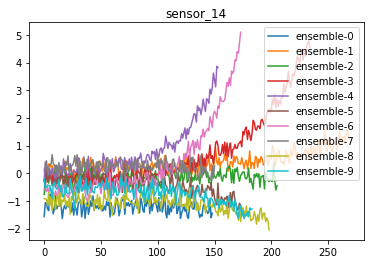

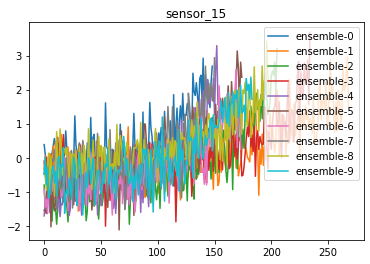

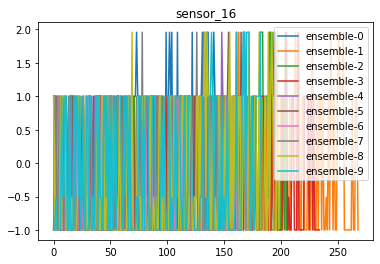

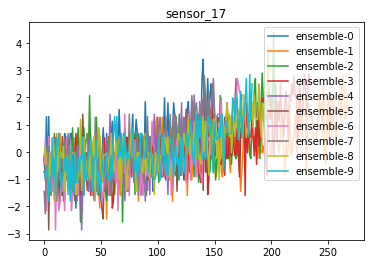

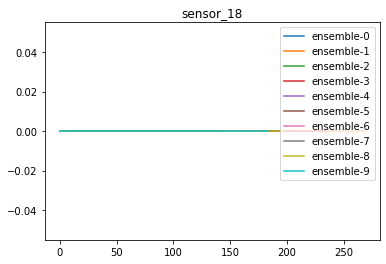

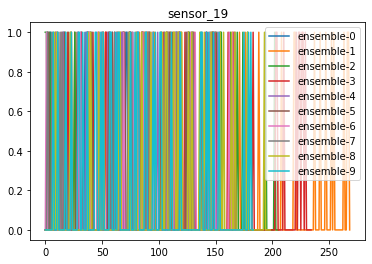

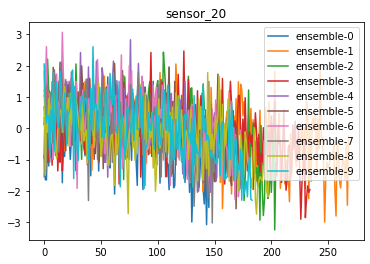

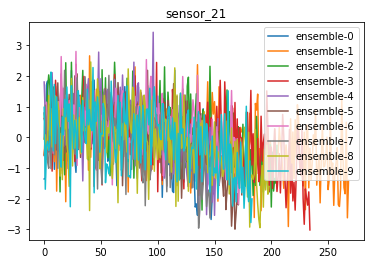

In [ ]:
# Let's plot again  (Call split and Plot functions)
plot_func(sensor_header, header_names, normalized_train_data_list)

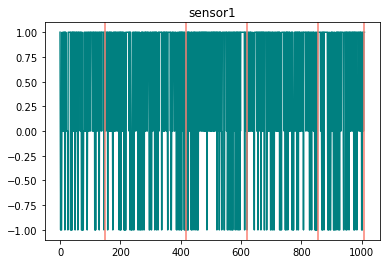

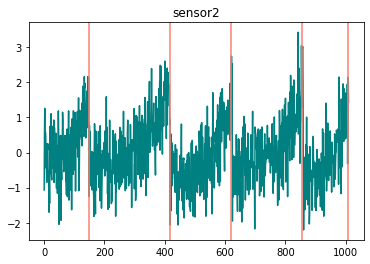

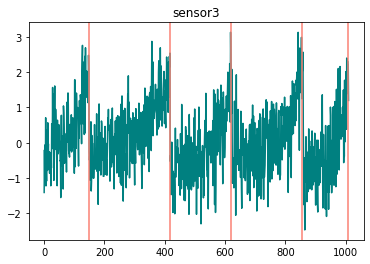

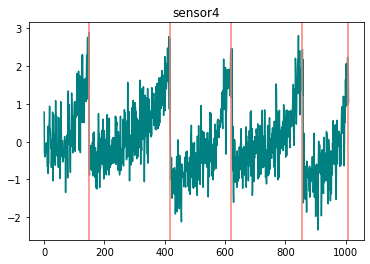

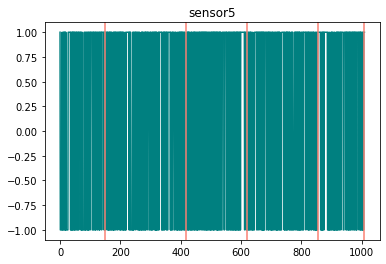

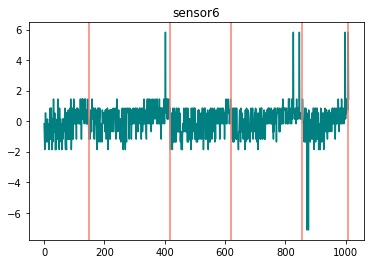

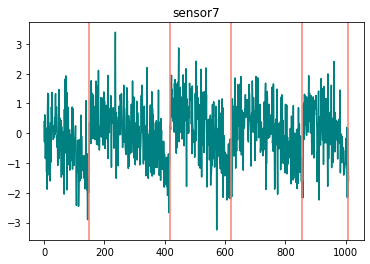

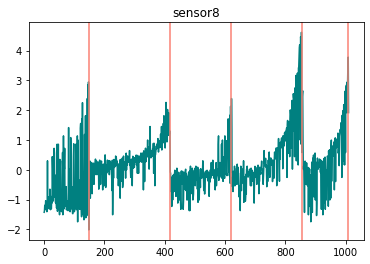

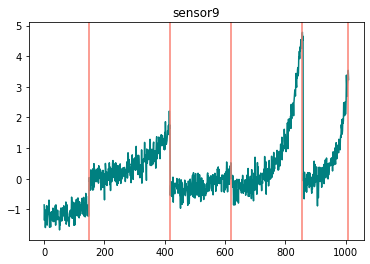

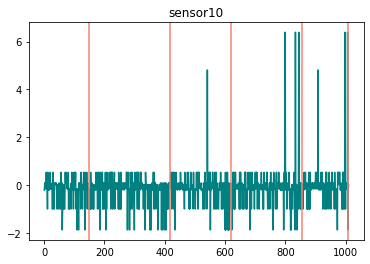

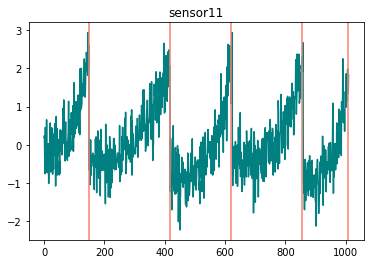

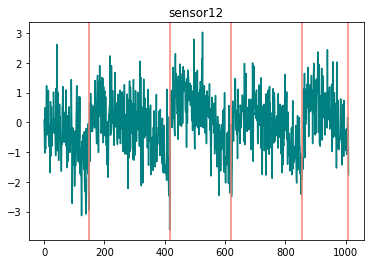

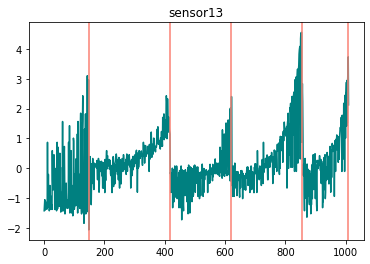

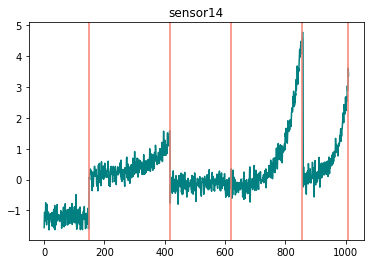

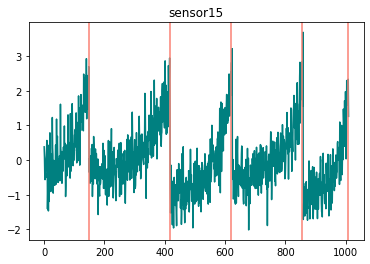

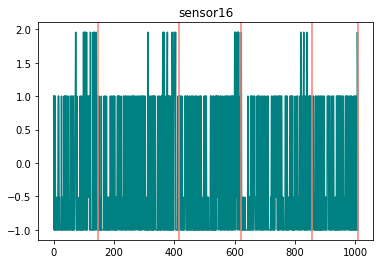

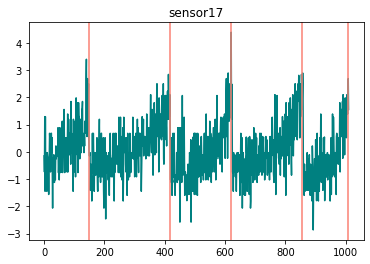

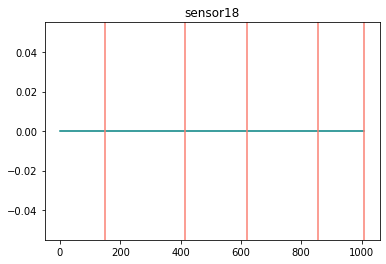

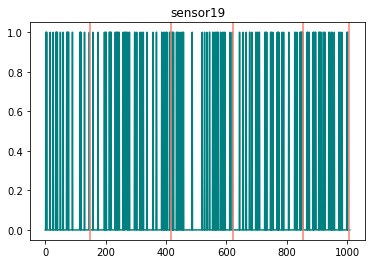

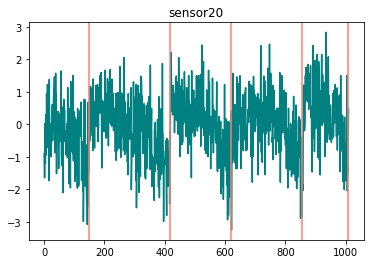

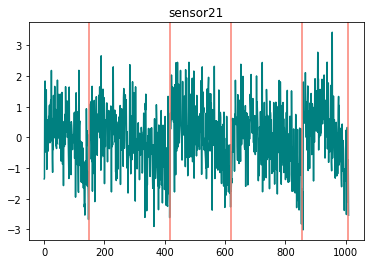

In [ ]:
cycle_plot_func_a(normalized_unwrap_train_data, sensor_n_list=None, n_samp=1010)

# Feature Selection

Trendability Analysis - The most trendable features were selected and identified by fitting a linear degradation model to the data and choosing the sensors with the largest slopes.

Just Use Linear Regression - x=time, y=sensor values.

In [ ]:
from scipy import stats
from scipy.optimize import curve_fit

In [ ]:
np.arange(len(normalized_train_data_list[0]))

In [ ]:
# Regression data list
reg_data_list = []
ensemble_shape_list = []
for l in normalized_train_data_list:
  reg_data = l[:,-21:]
  # print(reg_data.shape)
  ensemble_shape_list.append(reg_data.shape)
  reg_data_list.append(reg_data)
print(len(reg_data_list))
print(len(ensemble_shape_list))

In [ ]:
sensor_result_list = []
for n_sensor in range(normalized_unwrap_train_data.shape[1]):
  instance_result_list = []
  for n_list in (reg_data_list):
    x=np.arange(len(n_list))
    y=n_list[:,n_sensor] # Y is single sensor data
    res = stats.linregress(x, y)
    instance_result_list.append((res.slope, res.intercept,res.rvalue))
  sensor_result_list.append(instance_result_list)

In [ ]:
sensor_result_list[0][0]

(0.003079992744422275, 0.18818791946308724, 0.18056678829311482)

In [ ]:
# sensor_result_list
average_results_list = []
for loop in sensor_result_list:
  old_mean = np.zeros(3)
  for li, loopm in enumerate(loop):
    new_mean = old_mean + (1/(li+1))*(np.array(loopm)**2 - old_mean)    # Mean squared values
    old_mean = new_mean
  average_results_list.append(new_mean)

In [ ]:
# The avrage R-values: Goodness of fit measure is used to choose the best sensors
average_results_list

In [ ]:
average_results_list[1][0]

0.00011332939003077349

In [ ]:
# Let's save some lists and variables for next time
checkpoint_sensor_result_list = list_checkpoints('sensor-result-list', sensor_result_list)
checkpoint_saverage_results_list = list_checkpoints('average-results-list', average_results_list)

In [ ]:
# Collect the r-values in the list and sort in descending order - Choose best 8
r_values_array = np.zeros(len(average_results_list))
for r_i, r_v in enumerate(average_results_list):
  r_values_array[r_i] = r_v[-1]

In [ ]:
sensor_sort = np.argsort(r_values_array)+1

In [ ]:
best_eight = sensor_sort[-10:]

In [ ]:
best_eight

array([13, 12,  3,  2, 17,  9, 14, 15,  4, 11])

In [ ]:
# Collect the r-values in the list and sort in descending order - Choose best 8
r_values_array = np.zeros(len(average_results_list))
for r_i, r_v in enumerate(average_results_list):
  r_values_array[r_i] = r_v[0]

In [ ]:
sensor_sort = np.argsort(r_values_array)+1

In [ ]:
best_eight = sensor_sort[-8:]

In [ ]:
sord_best_eight = np.sort(best_eight)

In [ ]:
# Save best eight
checkpoint_best_eight = checkpoints('best-eight', best_eight)

So Our best Sensors Are: 2,3,4,9,11,14,15,17 contrary to MATLAB were theirs were: 2,3,4,7,11,12,15,17 (Off by 11 and 12).




In [ ]:
sord_best_ten = np.sort([13, 12,  3,  2, 17,  9, 14, 15,  4, 11])

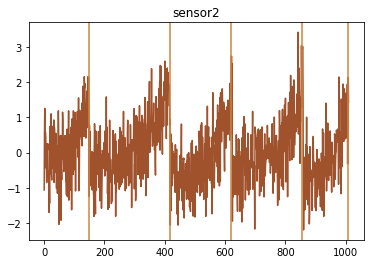

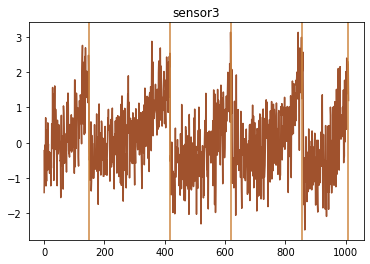

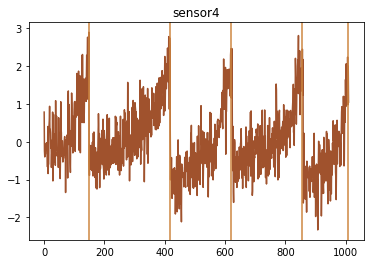

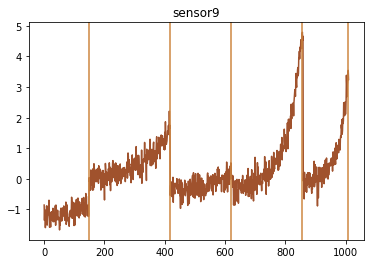

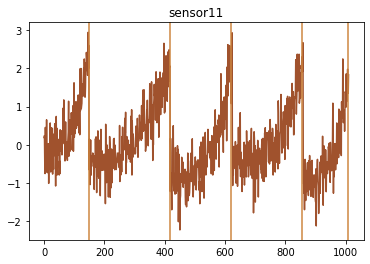

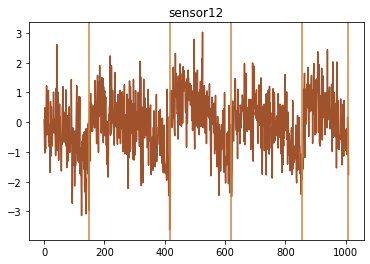

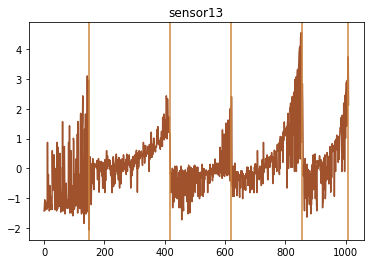

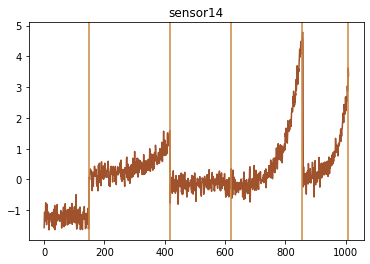

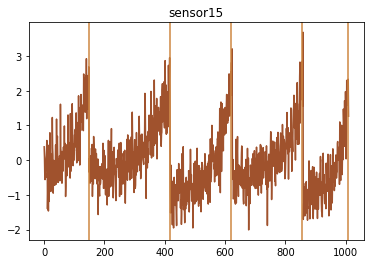

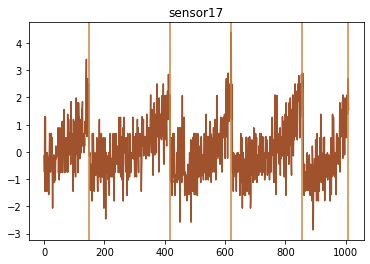

In [ ]:
# Plot best ten
cycle_plot_func_a(data=normalized_unwrap_train_data, sensor_n_list=sord_best_ten)

In [ ]:
# Our best Sensors Are: 2,3,4,9,11,14,15,17
mt_best_eight = np.array([2,3,4,9,11,14,15,17])
cycle_plot_func_a(normalized_unwrap_train_data, sensor_n_list=mt_best_eight)

In [ ]:
# I am trying to use just sums of weights 
sums_results_list = []
for loop in sensor_result_list:
  sums = np.zeros(3)
  for li, loopm in enumerate(loop):
    sums+=np.array(loopm)**2
  sums_results_list.append(sums)

In [ ]:
# Even with sum-squared, the best metric to choose sensors that fits a linear degradation model best is still the R-values
sums_results_list

# Machine Health Index construction/Sensor Fusion 

This is the process of mapping the features to a latent space or creating a representation that depicts the machine condition overtime. Unsupervised learning approaches like PCA, AE/VAE(s) can be used to map the sensor values to a latent space of lower dimensions. In this model, a representaion of the machine condition based on how long it operates for before failure was used OR A degradation level from 0-1 (1 been the ebst and 0 the worst) is mapped to /   used to represent the levels of degradation. For future works; a PCA or VAE will be used for sensor fusion to maximize the relationship between the sensors.

In [ ]:
# Prepare X-train and y-train just as we did previously
# For x-train, just remove the best 8 sensor data from the array:
sorted_eight = np.sort(best_eight)
x_train = normalized_unwrap_train_data[:,sorted_eight-1]
print(x_train.shape)

(41456, 8)


Construct Health Indicators - The sensor fusion method seems a little basic but it is not, it uses the survival duration of each machine/instance to group the health condition, so even if it takes a machine/asset a longer to fail, it still pass through all these stages of failure and can be compared to another machine which is what I am really trying to do, I need this metric (level of degradation) irrespective of the time you reach it.

*   Then linear regression was used for prediction: Linear regression was not used to fuse the data together, without linear regression, we still have the sensor fusion but because we would have instances where the survival duration is unknown or instances that are right censored, we use a regressor to learn a mapping from the sensor values to the health index or fused values.
*   Don't mix the feature extraction method with the sensor fusion method or the health index estimation method. They all use a linear model or mapping and it might look like they are trying to do the same thing but they are not.






In [ ]:
health_index_list = []
for instance in normalized_train_data_list:
  rul = instance.shape[0] - instance[:,1]
  health_index = rul/max(rul)
  health_index_list.append(health_index)

In [ ]:
health_index_list[1].shape

(269,)

In [ ]:
import itertools
# Use itertools in python
health_index_unwrap = list(itertools.chain(*health_index_list))

# Some Checks
print(len(health_index_unwrap) == normalized_unwrap_train_fdata.shape[0])

# y_train
y_train = np.array(health_index_unwrap)

# More checks
print(y_train.shape, x_train.shape[0])

True
(41456,) 41456


In [ ]:
checkpoint_health_index_unwrap = checkpoints('health-index-unwrap', np.array(health_index_unwrap))

Prepare Validation Data

In [ ]:
# Prepare X-val and y-val just as we did previously
# For x-val, just remove the best 8 sensor data from the array:
x_val = normalized_unwrap_val_data[:,sorted_eight-1]
print(x_val.shape)

(12303, 8)


In [ ]:
health_index_list = []
for instance in normalized_val_data_list:
  rul = instance.shape[0] - instance[:,1]
  health_index = rul/max(rul)
  health_index_list.append(health_index)

In [ ]:
len(health_index_list)

60

In [ ]:
import itertools
# Use itertools in python
health_index_unwrap = list(itertools.chain(*health_index_list))

# Some Checks
print(len(health_index_unwrap) == normalized_unwrap_val_fdata.shape[0])

# y_train
y_val = np.array(health_index_unwrap)

# More checks
print(y_val.shape, x_val.shape[0])

True
(12303,) 12303


In [ ]:
checkpoint_health_index_val_unwrap = checkpoints('health-index-val-unwrap', np.array(health_index_unwrap))

Let's save some variables

In [ ]:
# Save x-train, y-train, x-val, y-val
checkpoint_x_train = checkpoints('x-train', x_train)
checkpoint_y_train = checkpoints('y-train', y_train)
checkpoint_x_val = checkpoints('x-val', x_val)
checkpoint_y_val = checkpoints('y-val', y_val)

Now Let's train

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import PredefinedSplit, cross_val_score
ps = PredefinedSplit(x_val[5000])

models = {"alpha 0.001": Ridge(alpha=0.001),
          "alpha 0.003": Ridge(alpha=0.003),
          "alpha 0.01": Ridge(alpha=0.01),
          "alpha 0.03": Ridge(alpha=0.03),
          "alpha 0.1": Ridge(alpha=0.1),
          "alpha 0.3": Ridge(alpha=0.3),
          "alpha 0.5": Ridge(alpha=0.5)}

results = []
for model in models.values():
  model.fit(x_train,y_train)
  result = model.score(x_val[:5000], y_val[:5000])
  results.append(result)


In [ ]:
results

[0.6462992104749559,
 0.6462992111123256,
 0.6462992133431038,
 0.6462992197166222,
 0.6462992420223784,
 0.646299305739753,
 0.646299369437344]

In [ ]:
# Now let's train
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=0.03)
ridge.fit(x_train,y_train)
result = ridge.score(x_val[:5000],y_val[:5000])

In [ ]:
# Let's see how sklearn ridgeCV behaves
from sklearn.linear_model import RidgeCV
clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(x_train, y_train)
clf.score(x_val[:5000], y_val[:5000])


0.6462995285944415

In [ ]:
clf.get_params()

{'alpha_per_target': False,
 'alphas': [0.001, 0.01, 0.1, 1],
 'cv': None,
 'fit_intercept': True,
 'gcv_mode': None,
 'scoring': None,
 'store_cv_values': False}

In [ ]:
y_pred = clf.predict(x_val)

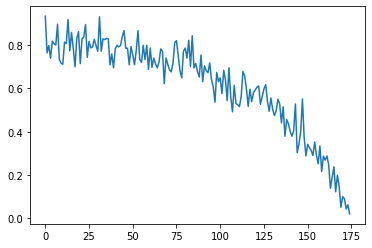

In [ ]:
plt.plot(y_pred[:175]);

Observation: The accuracy of is very low. Due to the temporal relationship and autocorrelation in timeseries data, a regular linear regression model might be underfit for the problem. Also, to capture the correlation in time series data, the data needs to be prepared (use a sliding window) adequately while choose the right order (T/P). For the purpose of this simple example and as a basis for comparison, a simple linear regression is used here. The 'Health Index Prediction Notebook contains more advanced and better performing prediction models.'

# Create Health Indices Dataframe

The final dataframe will contain columns:
1.  ori_HI: This refers to the health index(HI) that we constructed and mapped to the data instances over their lifetime. It goes from [0-1].
2.  apprx_HI: HI's learnt by the linear regression model.

1.   new_HI: The approximated HI's is fit to a polynomial function to reduce flunctuations and ensure that all instances have the same degradation profile and are comparable.


In [ ]:
# Note the y_train and y_val are the new health index - Create a dataframe
col_names = ['Unit_id', 'Time']
HItrain_df = pd.DataFrame(norm_train_fdata[:,:2], columns=col_names)
HIval_df = pd.DataFrame(norm_val_fdata[:,:2], columns=col_names)

In [ ]:
HItrain_df.shape

(41456, 2)

In [ ]:
HItrain_df['apprx_HI'] = y_train
HIval_df['apprx_HI'] = y_val

In [ ]:
HIval_df.head()

Unit_id  Time  apprx_HI
0    201.0   1.0  1.000000
1    201.0   2.0  0.994737
2    201.0   3.0  0.989474
3    201.0   4.0  0.984211
4    201.0   5.0  0.978947

Maxcycle Dataframe contains the RUL of all data instances.

In [ ]:
HIval_df.groupby('Unit_id').max()['Time'].reset_index().rename(columns={'Time':'Max_cycle'})

In [ ]:
max_cycles_df = HItrain_df.groupby(['Unit_id'], sort=False).max()['Time'].reset_index().rename(columns={'Time':'Maxcycle'})
max_cycles_df.head()

Unit_id  Maxcycle
0      1.0     149.0
1      2.0     269.0
2      3.0     206.0
3      4.0     235.0
4      5.0     154.0

In [ ]:
# Merge with original train dataset
HItrain_df = pd.merge(HItrain_df, max_cycles_df, how='inner', on='Unit_id')
HItrain_df.head()

Unit_id  Time  apprx_HI  Maxcycle
0      1.0   1.0  1.000000     149.0
1      1.0   2.0  0.993243     149.0
2      1.0   3.0  0.986486     149.0
3      1.0   4.0  0.979730     149.0
4      1.0   5.0  0.972973     149.0

In [ ]:
# Create RUL Column
HItrain_df['RUL'] = HItrain_df['Maxcycle'] - HItrain_df['Time']

In [ ]:
# HIVal
max_cycles_df = HIval_df.groupby('Unit_id').max()['Time'].reset_index().rename(columns={'Time':'Maxcycle'})
HIval_df = pd.merge(HIval_df, max_cycles_df, how='inner', on='Unit_id')
HIval_df['RUL'] = HIval_df['Maxcycle'] - HIval_df['Time']
HIval_df.head()

Polynomial Fit: A degradation function can be fit to the approximated HI for a smoother function, this approach is used in many papers in literature but the result of this model (HI prediction with linear regression shows a lower error compared to when fit with a polynomial regression model). 

In [ ]:
# Parameters_df: Fit a polynomial function to all instance's healthindex and store parameters in parameters_df
# The historical data for each member of the data ensemble is fitted with a model of identical structure.
# New degradation path that our data is following....
params_list = []
for id in HItrain_df['Unit_id'].unique():
  temp_df = HItrain_df[HItrain_df['Unit_id']==id]
  params = np.polyfit(x=temp_df['Time'], y=temp_df['apprx_HI'], deg=2)
  params_list.append(params)
len(params_list)

200

In [ ]:
# New Health Index based on the fitted model (Polynomial fit)
for id in HItrain_df['Unit_id'].unique():
  temp_df = HItrain_df[HItrain_df['Unit_id']==id]
  temp_new_HI = np.polyval(p=params_list[int(id)-1], x=temp_df['apprx_HI'])
  HItrain_df.loc[HItrain_df['Unit_id']==id, 'new_HI'] = temp_new_HI
HItrain_df.head()

Unit_id  Time    ori_HI  Maxcycle  RUL    new_HI  apprx_HI
0        1     1  1.000000       149  148  0.582822  0.546977
1        1     2  0.993243       149  147  0.582912  0.581504
2        1     3  0.986486       149  146  0.582965  0.601732
3        1     4  0.979730       149  145  0.583290  0.726264
4        1     5  0.972973       149  144  0.582879  0.568990

In [ ]:
# The degradation data of the test component is used to compute 1-step prediction errors, or residuals, for each ensemble model.
# The magnitudes of these errors indicate how similar the test component is to the corresponding ensemble members.
# Estimate RUL for Validation set 1

In [ ]:
# Compute Residuals
from sklearn.metrics import mean_squared_error
import math

In [ ]:
# 50% prediction i.e estimation from half the time
lent = math.ceil(val_set.shape[0]/2)
cur_val = val_set['apprx_HI'][:lent]
cur_val.shape

In [ ]:
# Estimate residuals
cur_train = HItrain_df['new_HI'][:cur_val.shape[0]]
cur_train.shape

(96,)

In [ ]:
# Lenght of the difference btw two vectors
residual = mean_squared_error(cur_train, cur_val, squared=True)
residual

0.08523154441176817

Reloading HItrain and val and formatting.

In [ ]:
# Load HItrain and HIval back in
HItrain_df = pd.read_csv('/content/HItrain-df (1)')
HIval_df = pd.read_csv('/content/HIval-df (1)')

In [ ]:
HItrain_df = HItrain_df.rename(columns={'apprx_HI': 'ori_HI'})
HItrain_df.head()

Unit_id  Time    ori_HI  Maxcycle    RUL    new_HI
0      1.0   1.0  1.000000     149.0  148.0  1.000000
1      1.0   2.0  0.993243     149.0  147.0  1.000046
2      1.0   3.0  0.986486     149.0  146.0  1.000091
3      1.0   4.0  0.979730     149.0  145.0  1.000137
4      1.0   5.0  0.972973     149.0  144.0  1.000183

In [ ]:
# typecast unit_id column
HItrain_df[['Unit_id', 'Time', 'Maxcycle', 'RUL']] = HItrain_df[['Unit_id','Time', 'Maxcycle','RUL']].astype('int64')
HItrain_df.head()

Unit_id  Time    ori_HI  Maxcycle  RUL    new_HI
0        1     1  1.000000       149  148  1.000000
1        1     2  0.993243       149  147  1.000046
2        1     3  0.986486       149  146  1.000091
3        1     4  0.979730       149  145  1.000137
4        1     5  0.972973       149  144  1.000183

In [ ]:
# typecast unit_id column
HIval_df[['Unit_id', 'Time', 'Maxcycle', 'RUL']] = HIval_df[['Unit_id','Time', 'Maxcycle','RUL']].astype('int64')
HIval_df.head()

Unit_id  Time    ori_HI  Maxcycle  RUL
0      201     1  1.000000       191  190
1      201     2  0.994737       191  189
2      201     3  0.989474       191  188
3      201     4  0.984211       191  187
4      201     5  0.978947       191  186

In [ ]:
# Save HI dataframes
HItrain_df.to_csv('HItrain-df', index=False)
HIval_df.to_csv('HIval-df', index=False)

# Residual-Similarity-Based RUL estimation.

For debugging: RUL Estimation on a single instance of the validation set at 50% of its lifecycle was tested first then helper functions for all validation instances were developed. 

In [ ]:
# Now do this for all ensemble and sort 
# Train_df = whole ensemble, test_df = single instance, pct=percentage.....
def residual_func(train_df, test_df, pct):
  residual = np.zeros(train_df['Unit_id'].unique().shape[0])
  lent = math.ceil(test_df.shape[0]*pct)
  cur_val = test_df['apprx_HI'][:lent]
  for id in train_df['Unit_id'].unique():
    temp_df = train_df[train_df['Unit_id']==id]
    cur_train = temp_df['new_HI'][:lent]
    residual[id-1] = mean_squared_error(cur_train, cur_val)
  return residual


In [ ]:
# Test 1
val = HIval_df[HIval_df['Unit_id']==201]
residual = residual_func(HItrain_df, val, 0.5)
residual.shape

(200,)

In [ ]:
# Nearest Neighbours - Closest == smallest distance
n_neighbors = np.argsort(residual)[:50]
n_neighbors

array([111,  87,  84, 117,  30, 157,  93, 104, 127, 155, 179, 134,  50, 152, 148,  80,  63,  31,
       130, 102, 147, 105,  10,   1, 123, 145,  40,  83, 170, 189, 126, 180, 144, 163,  11, 133,
        46,  90,  75, 158,  47,  72, 195, 156,   3, 112, 166,  74, 103,  12])

In [ ]:
# Take median of the maxcycle of nearest residuals or neighbours
# Instances maxcycle_df
max_cycle_df = HItrain_df.groupby('Unit_id').max()['Time'].reset_index().rename(columns={'Time':'max_cycle'})
max_cycle_df.head()

Unit_id  max_cycle
0        1        149
1        2        269
2        3        206
3        4        235
4        5        154

In [ ]:
max_cycle_df.set_index('Unit_id',inplace=True)
max_cycle_df.head()

max_cycle
Unit_id           
1              149
2              269
3              206
4              235
5              154

In [ ]:
max_cycle_df.loc[n_neighbors]

In [ ]:
test_df = HIval_df[HIval_df['Unit_id'] == 201]
lent = math.ceil(test_df.shape[0]*0.5)
ens_RULs = max_cycle_df.loc[n_neighbors] - lent

In [ ]:
ens_RULs['max_cycle'].median()

110.5

In [ ]:
true_RUL = test_df.shape[0] - lent
true_RUL

95

In [ ]:
test_df.shape

(191, 5)

Putting all supporting codes together: RUL Estimation for single instance with 50%, 70%, 90% of the first validation data to estimate or predict its RUL.

In [ ]:
# This is the residual function we are using because the lent can be larger than some instance's maxcycles.....
def residual_func(train_df, test_df, lent):
  no_instances = train_df['Unit_id'].unique().shape[0]
  res_mat = np.zeros((lent, no_instances))
  cur_val = test_df['apprx_HI'][:lent]
  for id in train_df['Unit_id'].unique():
    # If it is already dead, then maybe you shouldn't be part fo the computation OR add zeros below it
    temp_df = train_df[train_df['Unit_id']==id]
    if temp_df.shape[0] < lent:
      diff_arr = np.zeros(lent- temp_df.shape[0])
      cur_train = temp_df['apprx_HI'][:lent]
      cur_train = np.concatenate((cur_train, diff_arr), axis=0)
      res_mat[:,id-1] = cur_train
    else:
      temp_df = train_df[train_df['Unit_id']==id]
      cur_train = temp_df['apprx_HI'][:lent]
      res_mat[:,id-1] = cur_train

  l = res_mat - cur_val.to_numpy().reshape((-1,1))
  residual = np.mean(l**2, axis=0)
  return residual

In [ ]:
test_df = HIval_df[HIval_df['Unit_id'] == 201]
residual = residual_func(train_df=HItrain_df, test_df=test_df, lent=96)

In [ ]:
residual

In [ ]:
n_neighbors = np.argsort(residual)[:50]
n_neighbors

array([ 23,  21, 194,  85, 173,  39, 153,  13,  20,  92,  58,  70, 138, 161, 185,  91,  89,  88,
        32,  25,  71,  34,  67, 121,  76, 168,  94,  61,   9, 151,  53,   8, 125, 131,  81,  27,
       110, 181, 137, 129,  45, 128, 174,  98,  78, 178, 176, 162, 113,  35])

In [ ]:
#  The function for new data will be a little different from that of val data
def RUL_estimator(train_df, test_df, max_cycle_df, pct, nearest):
  # Call Lenght Function
  lent = lenght(test_df,pct)

  # Call Residual Function
  residual = residual_func(train_df, test_df, lent)

  # Nearest neighbours function - where you can change the size of nearest neighbours
  n_neighbors = neighbors(residual,nearest)

  # RUL Estimation
  # We want the closest 50 that are not yet dead
  ens_RULs = max_cycle_df.loc[n_neighbors+1] - lent

  true_RUL = test_df.shape[0] - lent

  m = ens_RULs[ens_RULs>-10]
  m[m.isna()] = 0

  est_RUL = m['max_cycle'].median()

  return (est_RUL, true_RUL, (ens_RULs))
  # return lent, residual, n_neighbors

In [ ]:
# Call function
test_df = HIval_df[HIval_df['Unit_id'] == 202]
est_RUL, true_RUL, ens_RULs = RUL_estimator(train_df=HItrain_df, test_df=test_df, max_cycle_df=max_cycle_df, pct=0.5, nearest=50)
print(est_RUL, true_RUL)

100.5 98


In [ ]:
# Call function
test_df = HIval_df[HIval_df['Unit_id'] == 202]
est_RUL, true_RUL, ens_RULs = RUL_estimator(train_df=HItrain_df, test_df=test_df, max_cycle_df=max_cycle_df, pct=0.7, nearest=50)
print(est_RUL, true_RUL)

61.5 59


In [ ]:
# Call function
test_df = HIval_df[HIval_df['Unit_id'] == 202]
est_RUL, true_RUL, ens_RULs = RUL_estimator(train_df=HItrain_df, test_df=test_df, max_cycle_df=max_cycle_df, pct=0.9, nearest=50)
print(est_RUL, true_RUL)

21.5 19


In the health index construction we did not take into consideration the relationship between the features, we forced a common degradation path on all the data instances. It isn't a bad idea (it is very intuitive) BUT let's see if we can use Machine Learning capabilities to get better results (Use VAE for sensor fusion and PCA). 

Let's find the average difference between the true and est_RULs for all validation set over different no of neighbours and at different stages. Let it be a function that takes in the desired no of neighbours and returns the average error at 50%, 70% and 90% intervals.

In [ ]:
# This is the residual function we are using because the lent can be larger than some instance's maxcycles.....
def residual_func(train_df, test_df, lent):
  no_instances = train_df['Unit_id'].unique().shape[0]
  res_mat = np.zeros((lent, no_instances))
  cur_val = test_df['apprx_HI'][:lent]
  for id in train_df['Unit_id'].unique():
    # If it is already dead, then maybe you shouldn't be part fo the computation OR add zeros below it
    temp_df = train_df[train_df['Unit_id']==id]
    if temp_df.shape[0] < lent:
      diff_arr = np.zeros(lent- temp_df.shape[0])
      cur_train = temp_df['new_HI'][:lent]
      cur_train = np.concatenate((cur_train, diff_arr), axis=0)
      res_mat[:,id-1] = cur_train
    else:
      temp_df = train_df[train_df['Unit_id']==id]
      cur_train = temp_df['new_HI'][:lent]
      res_mat[:,id-1] = cur_train

  l = res_mat - cur_val.to_numpy().reshape((-1,1))
  residual = np.mean(l**2, axis=0)
  return residual

In [ ]:
#  The function for new data will be a little different from that of val data
def RUL_estimator(train_df, test_df, max_cycle_df, pct, nearest):
  # Call Lenght Function
  lent = lenght(test_df,pct)

  # Call Residual Function
  residual = residual_func(train_df, test_df, lent)

  # Nearest neighbours function - where you can change the size of nearest neighbours
  n_neighbors = neighbors(residual,nearest)

  # RUL Estimation
  # We want the closest 50 that are not yet dead
  ens_RULs = max_cycle_df.loc[n_neighbors+1] - lent

  true_RUL = test_df.shape[0] - lent

  m = ens_RULs[ens_RULs>-10]
  m[m.isna()] = 0

  est_RUL = m['max_cycle'].median()

  return (est_RUL, true_RUL, (ens_RULs))
  # return lent, residual, n_neighbors

In [ ]:
def RUL_Estimator_coll(train_df, test_df, max_cycle_df, nearest):
  # Instantiate pct list:
  pct_list = [0.5,0.7,0.9]
  # Val_data unique ID
  inst_id = test_df['Unit_id'].unique()

  # Create a results dictionary:
  val_inst = {}
  for i in inst_id:
    val_inst[i] = {}
    for j in [0.5, 0.7, 0.9]:
      val_inst[i][j] = (0,0,())

  # Loop through all val_instances
  for k in inst_id:
    # Working with a single test set:
    for pct in [0.5, 0.7, 0.9]: 
      cur_val_df = test_df[test_df['Unit_id'] == k]
      val_inst[k][pct] = RUL_estimator(train_df=train_df, test_df=cur_val_df, max_cycle_df=max_cycle_df, pct=pct, nearest=nearest)

  return val_inst


In [ ]:
val_inst = RUL_Estimator_coll(train_df=HItrain_df, test_df=HIval_df, max_cycle_df=max_cycle_df, nearest=50 )

In [ ]:
type(val_inst)

dict

In [ ]:
def result_analysis(val_inst):
  fif = []
  sev = []
  nine = []
  EST_RUL_5 = []
  TRUE_RUL_5 = []
  ENS_RUL_5 = []
  EST_RUL_7 = []
  TRUE_RUL_7 = []
  ENS_RUL_7 = []
  EST_RUL_9 = []
  TRUE_RUL_9 = []
  ENS_RUL_9 = []
  id_list = []
  # loop through all instances:
  for id,info in val_inst.items():
    id_list.append(id)

    EST_RUL_5.append(info[0.5][0])
    TRUE_RUL_5.append(info[0.5][1])
    ENS_RUL_5.append(info[0.5][2])

    EST_RUL_7.append(info[0.7][0])
    TRUE_RUL_7.append(info[0.7][1])
    ENS_RUL_7.append(info[0.5][2])

    EST_RUL_9.append(info[0.9][0])
    TRUE_RUL_9.append(info[0.9][1])
    ENS_RUL_9.append(info[0.5][2])

  fif = [EST_RUL_5, TRUE_RUL_5, ENS_RUL_5]
  sev = [EST_RUL_7, TRUE_RUL_7, ENS_RUL_7]
  nine = [EST_RUL_9, TRUE_RUL_9, ENS_RUL_9]
  
  return fif, sev, nine
  # Calculate RMSE

In [ ]:
a,b,c = result_analysis(val_inst)
print(len(a) , len(b), len(c))

3 3 3


# Result Representation..



1.   The error = Estimated RUL - True RUL

2.   The mean, median and standard deviation the RUL prediction 
error using first 50%, 70% and 90%  of each validation ensemble data is evalauted.



In [ ]:
a[0]

In [ ]:
a[1]

In [ ]:
mean_error = np.mean(np.array(a[0]) - np.array(a[1]))

-1.8416666666666666

In [ ]:
mean_error = np.mean(np.array(b[0]) - np.array(b[1]))
mean_error

-1.8416666666666666

In [ ]:
mean_error = np.mean(np.array(c[0]) - np.array(c[1]))
mean_error

-0.6166666666666667

In [ ]:
# Error = Estimated - True RUL OR Vise versa
error_list = []
for s in [a,b,c]:
  error = np.array(s[0]) - np.array(s[1])
  error_list.append(error)

len(error_list)

3

In [ ]:
error_list[0]

array([  2. ,   2.5, -12.5,  -5.5,   2. ,  -3.5,   2. ,   9.5,   1. ,   2. ,  -4. ,  10.5,   3. ,
        13. ,  -5. ,  -6. ,   1.5,  -5.5,   6. ,  -7. ,   3. ,   1. ,  -6.5,   1.5,   6. ,   3. ,
         2. ,  -5.5,   1. ,   1.5,  15. ,  -3. ,   3. ,   3. ,   2. ,  -7. ,  -2. ,   6. ,  -6.5,
        -9.5,   2. , -14.5,  -6. ,  31. ,  -5. ,   0. ,   2.5,  -7. ,   0.5,   2. ,  -9.5,  24. ,
        10.5,  -3.5, -75. ,   3. , -44. ,  16. ,  -0.5, -51. ])

In [ ]:
# Error Statistics
print('error mean at 50%: ', np.mean(error_list[0]))
print('error median at 50%: ', np.median(error_list[0]))
print('error std at 50%: ', np.std(error_list[0]))

error mean at 50%:  -1.8416666666666666
error median at 50%:  1.25
error std at 50%:  15.120486011442297


In [ ]:
# Error Statistics
print('error mean at 70%: ', np.mean(error_list[1]))
print('error median at 70%: ', np.median(error_list[1]))
print('error std at 70%: ', np.std(error_list[1]))

error mean at 70%:  -1.8416666666666666
error median at 70%:  1.25
error std at 70%:  15.120486011442297


In [ ]:
# Error Statistics
print('error mean at 90%: ', np.mean(error_list[2]))
print('error median at 90%: ', np.median(error_list[2]))
print('error std at 90%: ', np.std(error_list[2]))

error mean at 90%:  -0.6166666666666667
error median at 90%:  1.25
error std at 90%:  10.62283964965217


In [ ]:
# Visualize the histogram of the error for each breakpoint together with its probability distribution.
import seaborn as sns

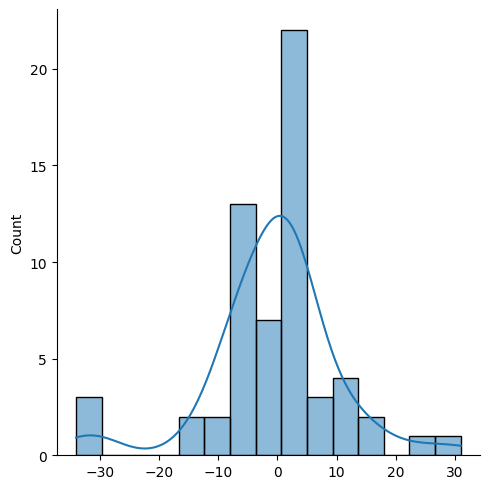

In [ ]:
sns.displot(error_list[2], kde=True);

# Result Discussion.

NOTE: The metric used here is the mean prediction error:
1.   Using the polynomial fitted model of the approximate model has an average error of 37.4 for 70% estimate, 46.8% for 50% and 27% on 90%.
2.   Without polynimial fit: 18.8 on 90%, 29.67 on 70% and 38.5 on 50%.
From this result, I am convinced that if we can get a higher accuracy of the HI prediction, the RUL estimation will have a better result close to the baseline.

1.   Using the actual/Original HI: 15.2 on 50% and 70%, and 10.6 on 90%. From this, you can tell that this is the best we can get with a residual similarity model. It is not an accurate estimate but it is close enough and should be quantified with an upper and lower bound.  
2. NEXT SECTION: Use more sophisticated models (Deep Learning) for health index prediction. See in "Health Index Prediction Models" notebook.


